# Imports

In [1]:
!pip install shap
!pip install fastcluster


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 4.1 MB/s eta 0:00:00


In [14]:
# Basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning preprocessing and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Specific model import
import xgboost as xgb

# Imbalanced dataset handling
from imblearn.over_sampling import SMOTE

# Optional: Advanced dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# Model explanability
import shap
import fastcluster

In [5]:
# reading data
Data = "dataset.csv"
df = pd.read_csv(Data)

In [6]:
# Drop unrelevant columns
columns_to_drop = ['encounter_id', 'patient_id', 'icu_id', 'Unnamed: 83']
df = df.drop(columns=columns_to_drop)

# Drop rows with null values in the target feature (hospital_death)
df = df.dropna(subset=['hospital_death'])

# Split target values from other features
X = df.drop(columns=['hospital_death'])
y = df['hospital_death']

In [7]:
columns = X.columns
categorical_columns = ['hospital_id','ethnicity', 'icu_admit_source', 'icu_type', 'icu_stay_type', 'gcs_eyes_apache', 'gcs_motor_apache',
                       'gcs_verbal_apache', 'apache_3j_bodysystem', 'apache_2_bodysystem']
binary_columns = ['elective_surgery', 'gender', 'apache_post_operative',  'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
numeric_columns =  [col for col in X.columns if col not in categorical_columns + binary_columns]

# Outliers

Outliers can significantly affect the performance of the machine learning model. They can distort the overall distribution of the data, leading to biased model estimates and poor generalization to new data.

Let's examine the distribution of our numeric feature values using box plots.

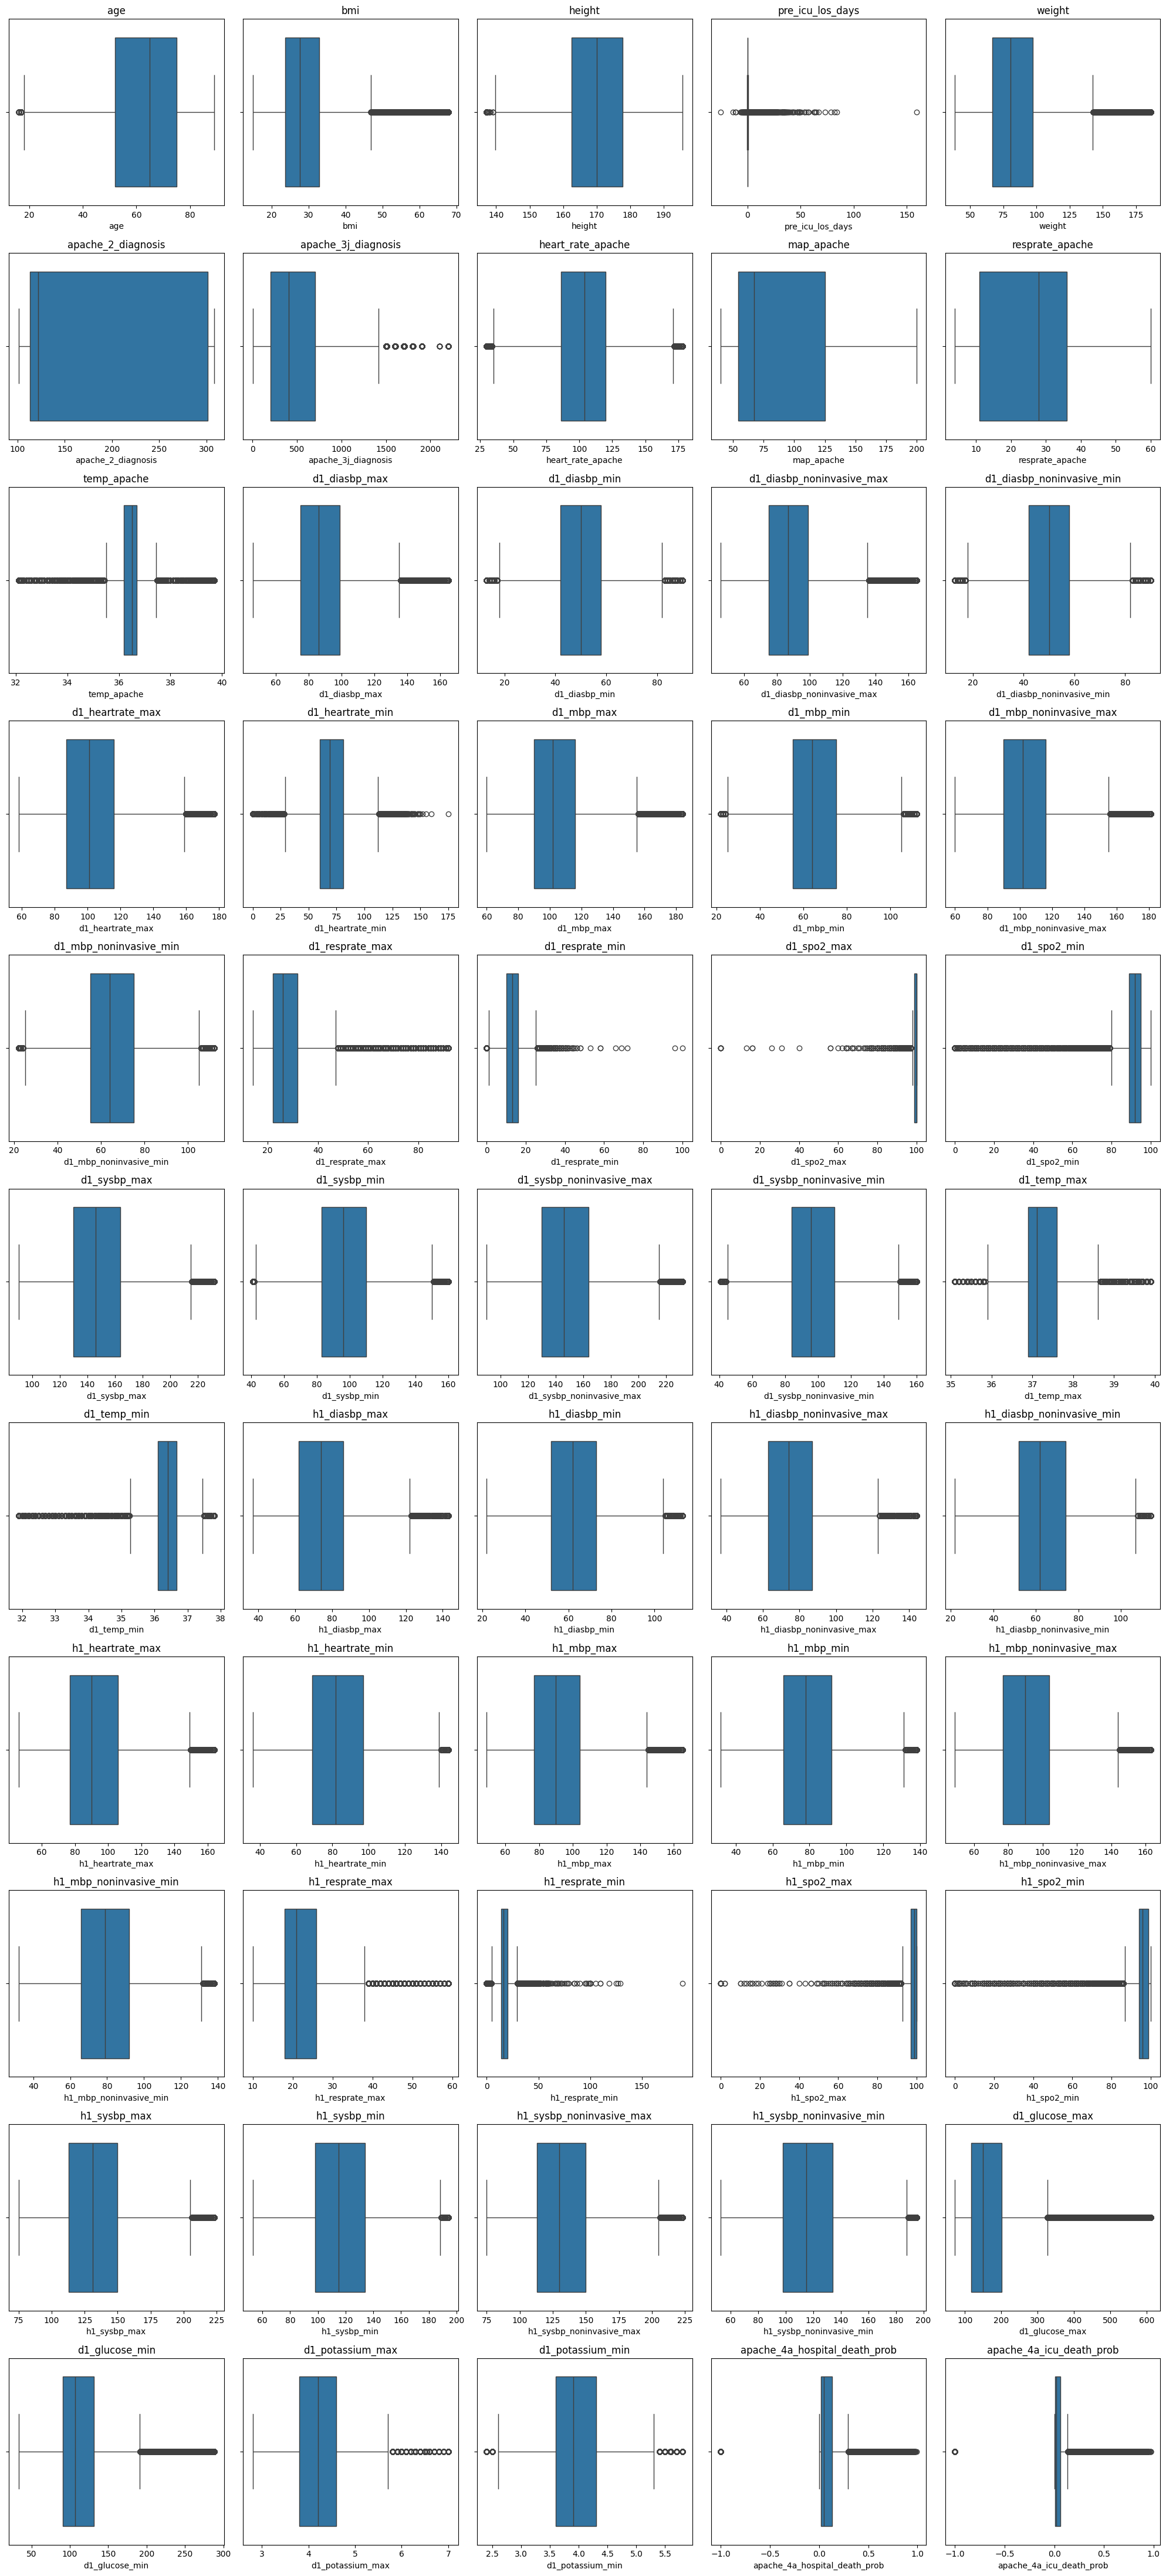

In [8]:
# Setting the number of columns in the grid of subplots
ncols = 5
# Calculating the required number of rows based on the number of numerical columns
nrows = (len(numeric_columns) + ncols - 1) // ncols

# Setting the size of the entire figure (width, height in inches)
plt.figure(figsize=(ncols * 4, nrows * 4))

for i, col in enumerate(numeric_columns):
    # Adding a subplot for each numerical column
    plt.subplot(nrows, ncols, i + 1)
    # Using seaborn to create the boxplot
    sns.boxplot(x=X[col])
    plt.title(col)

plt.tight_layout()
plt.show()

As we can see, there is an outliers problem in all the features and there are many features to address.
We suspect that several features in our dataset exhibit significant skewness (there is a long tail), therefore we may have outliers. Let's start by visualizing these distributions.

# Skewness

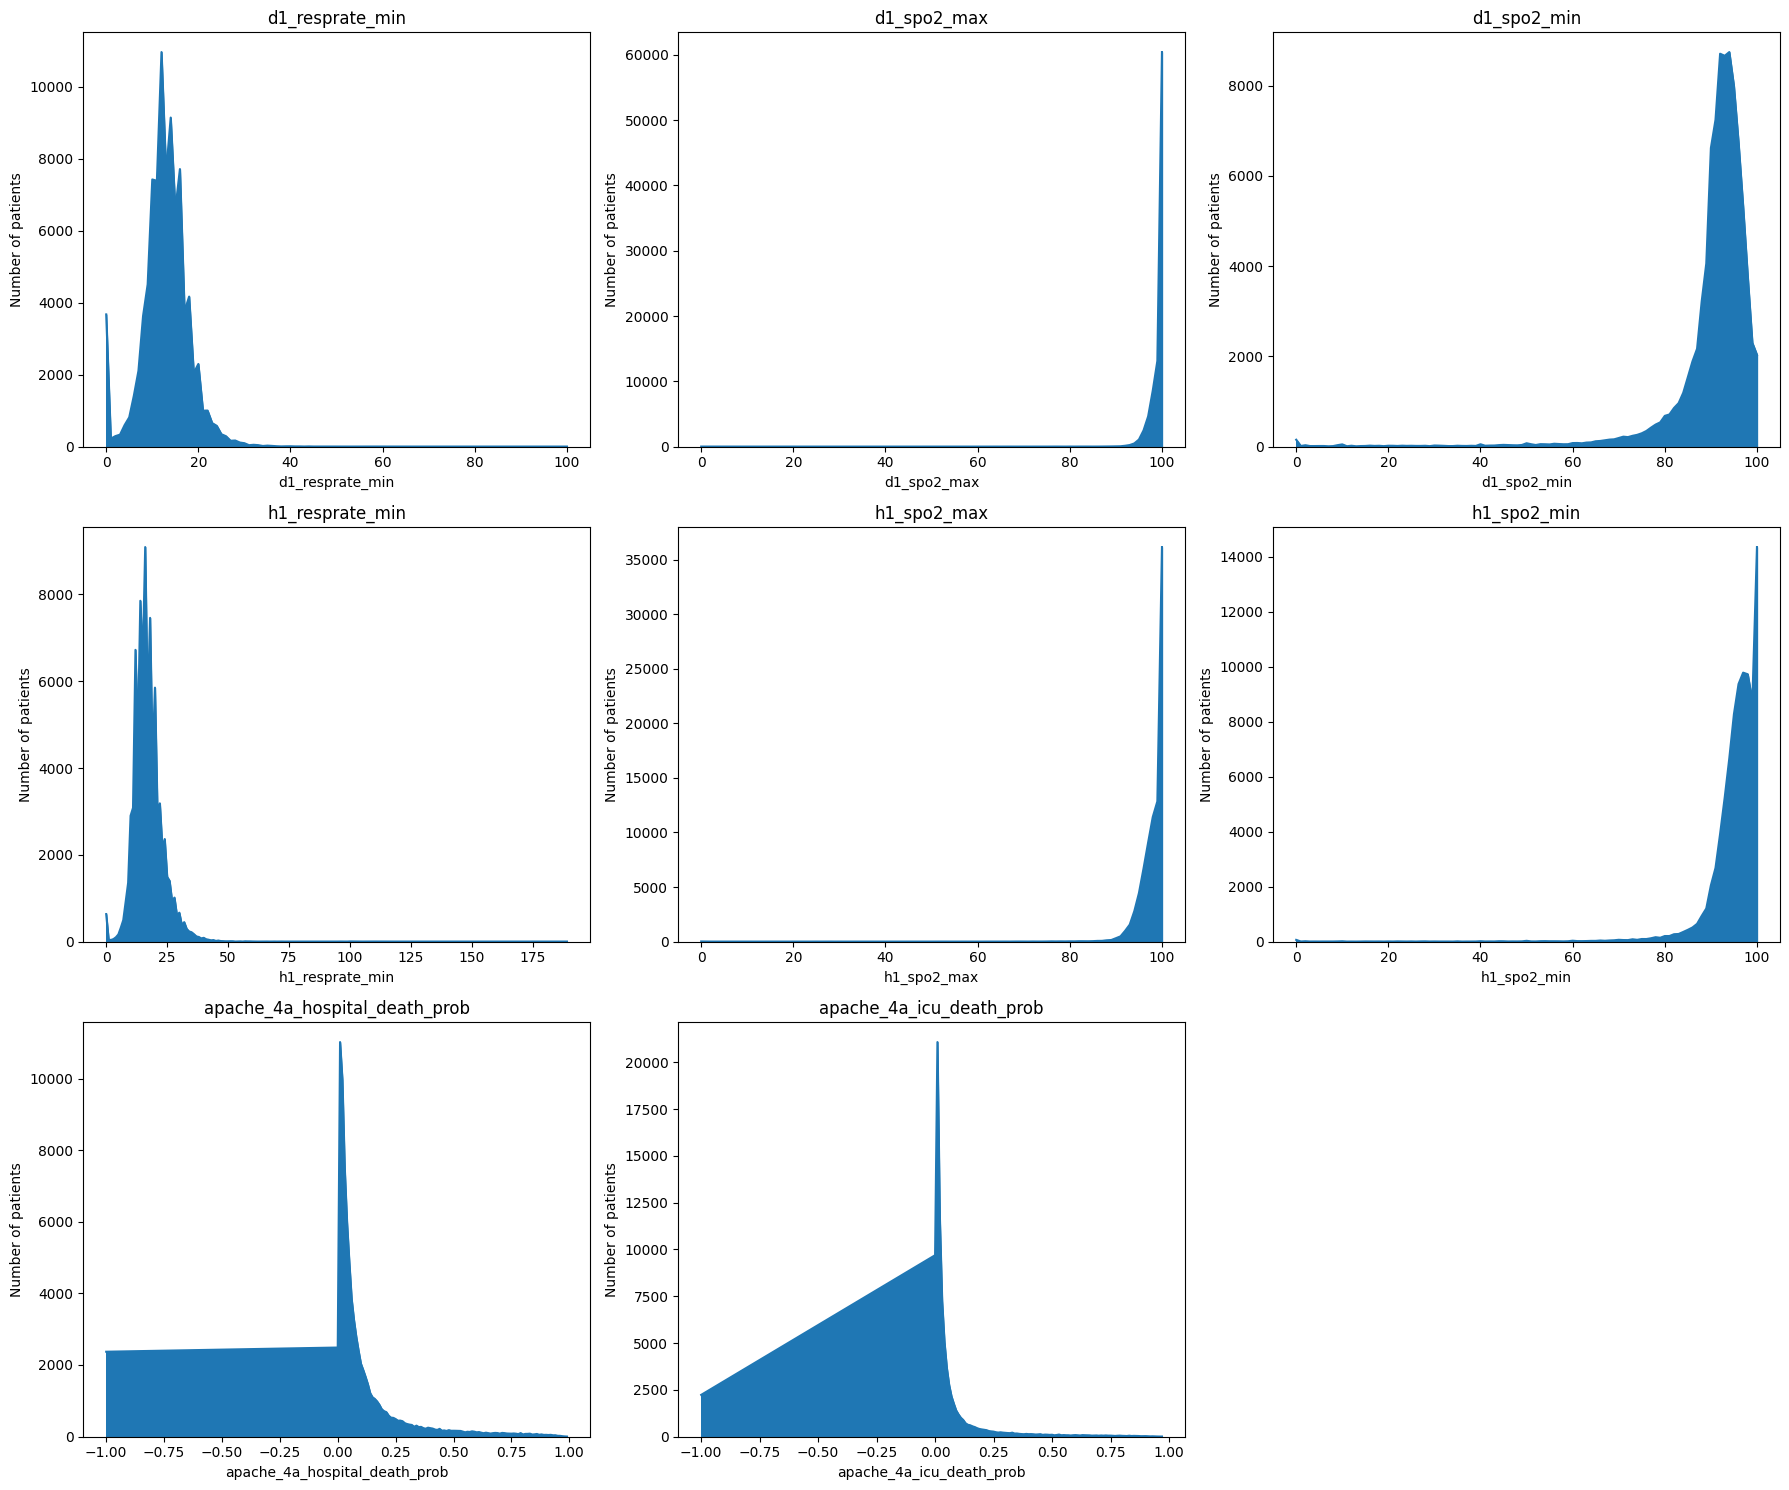

In [ ]:
def plot_feature_distributions(dataframe, features, cols=3):
    # Number of features determines the number of rows and columns in the grid
    nrows = int(np.ceil(len(features) / cols))

    # Create a figure with subplots in a grid defined by nrows and cols
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(cols * 6, nrows * 5))

    # Flatten axes array for easy iteration in case of one row or column
    axes = axes.flatten()

    # Loop through the features and create an area plot for each one
    for i, feature in enumerate(features):
        # Plot the value counts as an area plot, sorted by the index, on respective subplot
        dataframe[feature].value_counts().sort_index().plot.area(ax=axes[i], title=feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Number of patients')

    # If there are more subplots than features, turn off the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

selected_features = ['d1_resprate_min','d1_spo2_max', 'd1_spo2_min', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
plot_feature_distributions(X, selected_features)

# Examining the target feature - Imbalance of the target: 'hospital_death'

Amount of two classe in 'hospital death': 
 hospital_death
0    83798
1     7915
Name: count, dtype: int64 




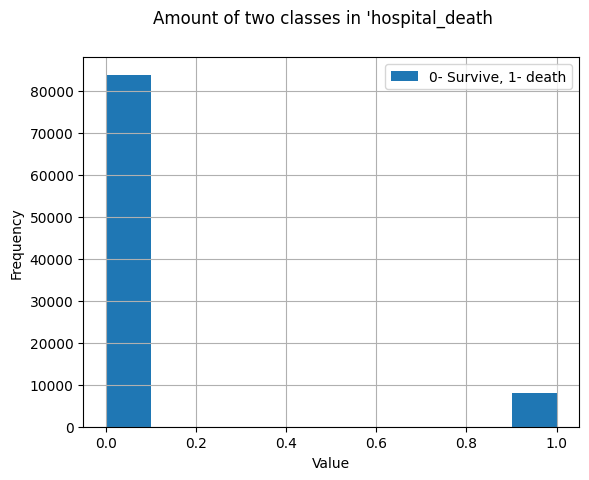

In [ ]:
# Imbalance of the target: 'hospital_death'
Data_count = y.value_counts()
print(f"Amount of two classe in 'hospital death': \n {Data_count} \n\n")

# Visualize two classes in 'hospital_death'
Data_hist = y.hist()
plt.suptitle("Amount of two classes in 'hospital_death")
plt.xlabel("Value")
plt.ylabel("Frequency")
Data_hist.legend(["0- Survive, 1- death"])


In [ ]:
# calculating proportion between control values and case values
print(f"Proportion of two classe in 'hospital death': {Data_count[0]/Data_count[1]}")

Proportion of two classe in 'hospital death': 10.587239418825016


Explanation: We can see that the target feature- hospital death is highly unbalanassed. It might impact the model performings or biased the results. We will need to dell with that, and to consider to balance the data with difference methods in order to get reliable results.

# Examining Correlations to the target feature

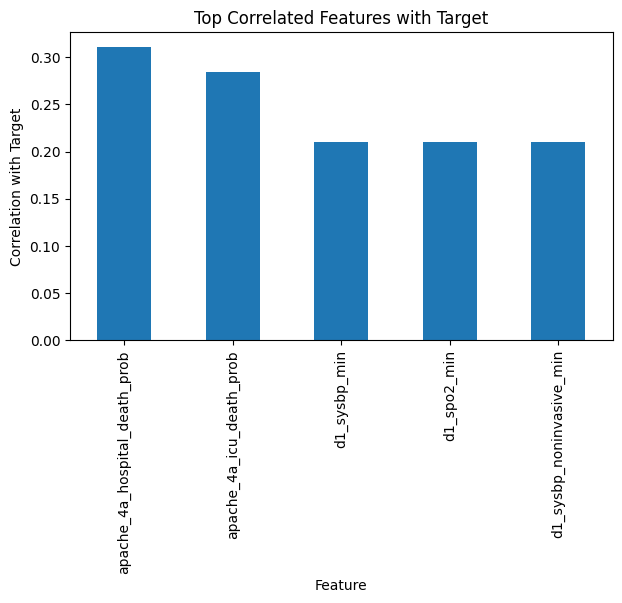

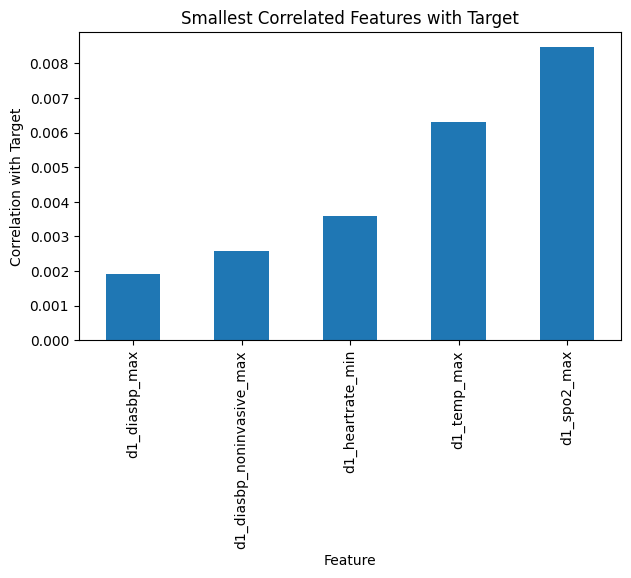

In [ ]:
# Calculating corelations
correlations = X[numeric_columns].corrwith(y).sort_values(ascending=False)
top_correlated_features = correlations.abs().nlargest(5)
leas_correlated_features = correlations.abs().nsmallest(5)

# visualization
# Top correlation
plt.figure(figsize=(7, 4))
top_correlated_features.plot(kind='bar')
plt.title('Top Correlated Features with Target')
plt.xlabel('Feature')
plt.ylabel('Correlation with Target')
plt.show()
# Smallest correlation
plt.figure(figsize=(7, 4))
leas_correlated_features.plot(kind='bar')
plt.title('Smallest Correlated Features with Target')
plt.xlabel('Feature')
plt.ylabel('Correlation with Target')
plt.show()

Explanation:

High correlations:

We found the top five features with the highest correlations with the target. We can see that non of then is extremly high. If we would have found an extremly high correlation, we should have done another test to find out if it should been remove to avoid bias in the learning.

Low correlation:

We found also the top five features with the lowest correlations with the target. We might consider to remove them, if we will suspect it adding a noise to the learning process.

# Interaction between age, gender, and hospital death

In [ ]:
# Assuming y_train is a Series, you should ensure it has an appropriate name for merging
y_train_named = y.rename('hospital_death')

# Merge X_train with y_train using the index
X_train_with_target = X.join(y_train_named)

# creating histogram of interaction between age, gender, and the target feature
fig = px.histogram(X_train_with_target[['age', 'gender', 'hospital_death']].dropna(), x= "age", y = "hospital_death", color = 'gender',
                  marginal = 'box', title= "Interaction between age, gender, and hospital death")


fig.show()

Explanation: We examine the impact of the gender feature, the age feature, and the interaction between both, on the target value.
We can relate to the following insights:
1. It seems that Woman has lowest hospital survival rate than men.
2. It seems that between the age of 50 and 60, the hospital survival rate begin to drop.
3. It seems that for woman, the affect of age on the surviving rate is starting at the age of 50, and along men at the age of 60.

# Data Preprocessing

To ensure that the machine learning pipeline avoids data leakage and maintains the integrity of the training and testing processes, we start with spliting the data into training and test sets before undertaking any kind of data preprocessing, such as imputation, normalization, or encoding.

In [9]:
# dividing the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Handling missing values, encoding the categorical and binary features and normalized the values in the numerical features.

In [10]:
# Defining Pre-processor pypline
preprocessor = ColumnTransformer(transformers=[
        ('numeric', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),        # Handling missing values
            ('scaler', StandardScaler())                          # Normalized numeric columns
        ]), numeric_columns),
        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
            ('encoder', OneHotEncoder(handle_unknown='ignore'))   # Encoding categorical columns
        ]), categorical_columns),
        ('binary', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
            ('encoder', OrdinalEncoder())                        # Encoding binary columns
        ]), binary_columns)
    ],
    remainder='passthrough'  # Keep any columns not explicitly specified in the transformers
)


# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting columns names
new_columns = preprocessor.get_feature_names_out()

In [11]:
# Getting the feature shape after one hot encoder
print(X_train_transformed.shape)

(73370, 275)


After applying one-hot encoding,  the dimensions have increased even further.

We will need to perform feature selection and dimensionality reduction later.

# Basic ML pipeline - Performing Learning and evaluation of the model

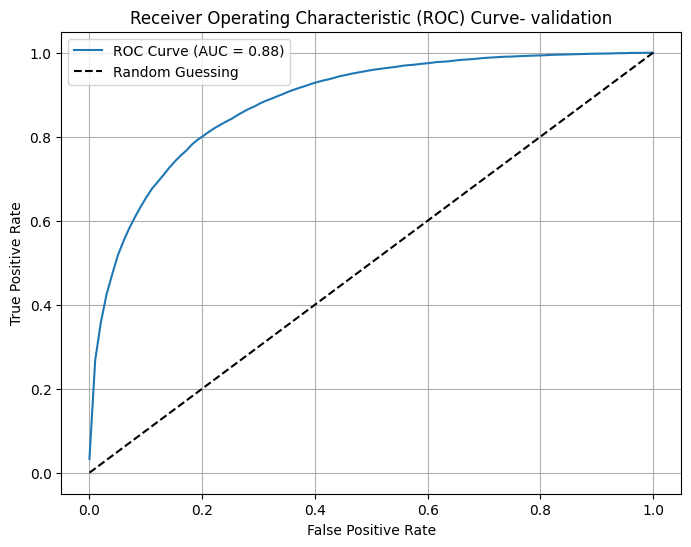

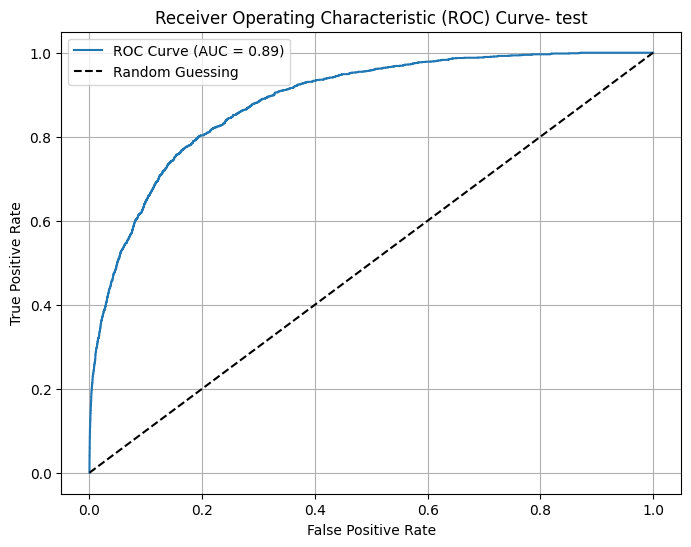

In [31]:
# Performing an XGBoost classifier

# defining model
model = xgb.XGBClassifier(random_state=42)

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train_transformed, X_valid_test_transformed, y_valid_train, y_valid_test = train_test_split(X_train_transformed, y_train, test_size=0.2)

  # training the model
  model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = model.predict_proba(X_valid_test_transformed)
  y_pred_binary = model.predict(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred_test = model.predict_proba(X_test_transformed)
y_pred_test_binary = model.predict(X_test_transformed)
auc_score_test = roc_auc_score(y_test, y_pred_test[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])

# Plot ROC curve

# mean validation sets
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = {:.2f})'.format(auc_score_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()



We decided to evaluate our model using AUC scoring method, as it particularly powerful method for evaluating classifiers on imbalanced and skewed datasets due to its insensitivity to class distribution.

We can see that we have nice results by the xgboost model (after a only basic pre-processing).
From the exploration data pare, we learn that:
1. The data is highly imbalance.
2. We have a lot of ouliers values in the numeric features.
3. We have a large amount of features, increased with the pre-processing that includes one-hot-encoding.
We will need to handle those issues in the next step, in order to improve the results of the model and make sure it reliable.

# **Improving the basic pipeline**

The clinical/medical data we worked on was particularly complex and challenging for several reasons.

First, due to its large size and the extensive number of dimensions involved. High-dimensional data poses unique challenges in terms of analysis and interpretation.

Second, the complexity of the features and their non-uniform distribution, often exhibiting significant skewness.

Third, the dataset was highly imbalanced.

 These factors primarily contributed to substantial computational complexity.

Our main efforts in developing our model were dedicated on reviewing the literature to find the most effective machine learning techniques and pipeline to handle our data's intricacies.

We implemented advanced feature selection and dimensionality reduction methods to construct a robust model that avoids overfitting and can generalize effectively for real-world scenarios.

The pipline we developed to improve model performance:
1. Trying another ML model
2. Handeling outliers
3. Handling imbalance data
4. Exploring feature importance by model explanability
5. Feature selection and dimention reduction
6. Hyper-parameters tuning


# Choose model

First we try alternative supervised machine-learning model, to compare and choose the one with the best performance.
We chose the AdaBoost (Adaptive Boosting), an ensemble learning method that combines multiple weak learners to create a strong learner. The weak learners will be the Decision Tree with shallow depth (we chose the max depth to be 1).
We use the same evaluation matrix: AUC and ROC curve, so that we could compare between the results of the basic models.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

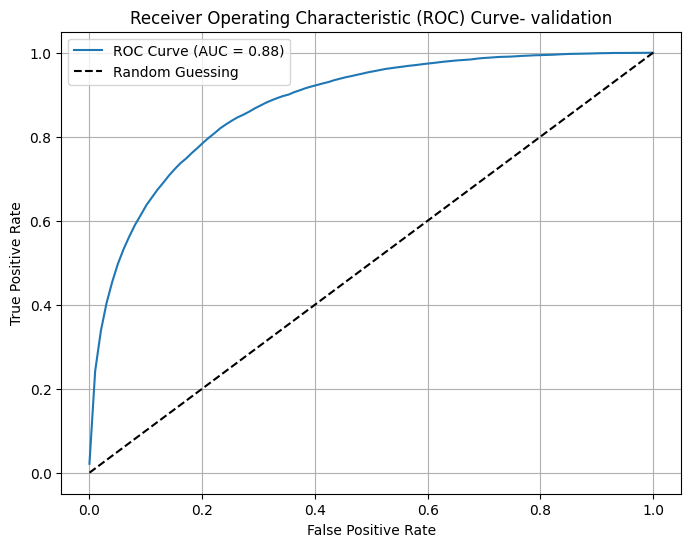

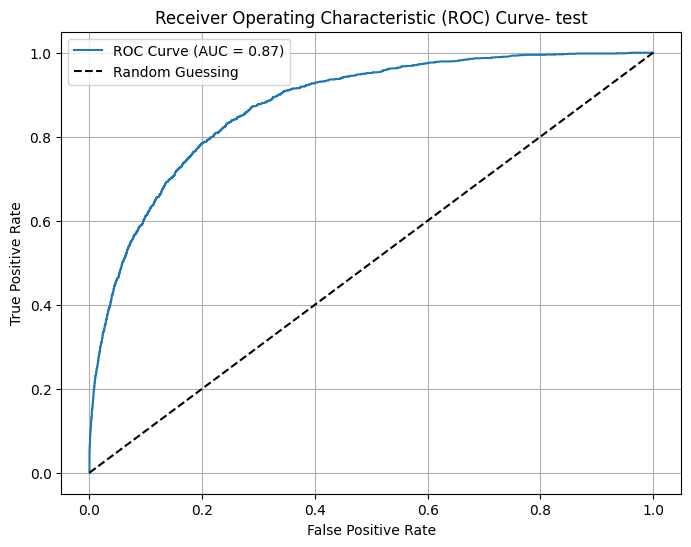

In [25]:
# Performing an adaBoost classifier

# defining model
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator = base_model, n_estimators=50)

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train_transformed, X_valid_test_transformed, y_valid_train, y_valid_test = train_test_split(X_train_transformed, y_train, test_size=0.2)

  # training the model
  adaboost_model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = adaboost_model.predict_proba(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred_test = adaboost_model.predict_proba(X_test_transformed)
auc_score_test = roc_auc_score(y_test, y_pred_test[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])

# Plot ROC curve

# mean validation sets
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = {:.2f})'.format(auc_score_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()

We can see that the XGboost performance are similar(and a little bit better) as the Adaboost. We will continue the following processing regarding this model.

# Handeling Outliers

**Capping or winsorizing:**

Capping or winsorizing is especially suitable approach for handling outliers in skewed datasets as it reduces the influence of extreme values without completely removing the data points.

By capping at the 95th percentile, we retain the bulk of the data but limit the impact of the extreme values.

In [ ]:
print("Original DataFrame shape:", X_train.shape)

# Initialize a counter for outliers
outliers_count = 0

# Define the columns to exclude
exclude_columns = ['pre_icu_los_days', 'apache_4a_icu_death_prob']

# Filter out the columns you want to exclude
filtered_numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Cap values at the 95th percentile for each numeric column
for col in filtered_numeric_columns:
    percentile_95 = X_train[col].quantile(0.95)
    original_train_col_data = X_train[col].copy()  # Copy original data for comparison

    # Apply capping to the training data
    X_train[col] = X_train[col].clip(upper=percentile_95)

    # Count how many values were capped
    outliers_count += (original_train_col_data > percentile_95).sum()


print("Filtered DataFrame shape:", X_train.shape)
print(f'Number of outliers modified: {outliers_count}')

Original DataFrame shape: (73370, 80)
Filtered DataFrame shape: (73370, 80)
Number of outliers modified: 166525


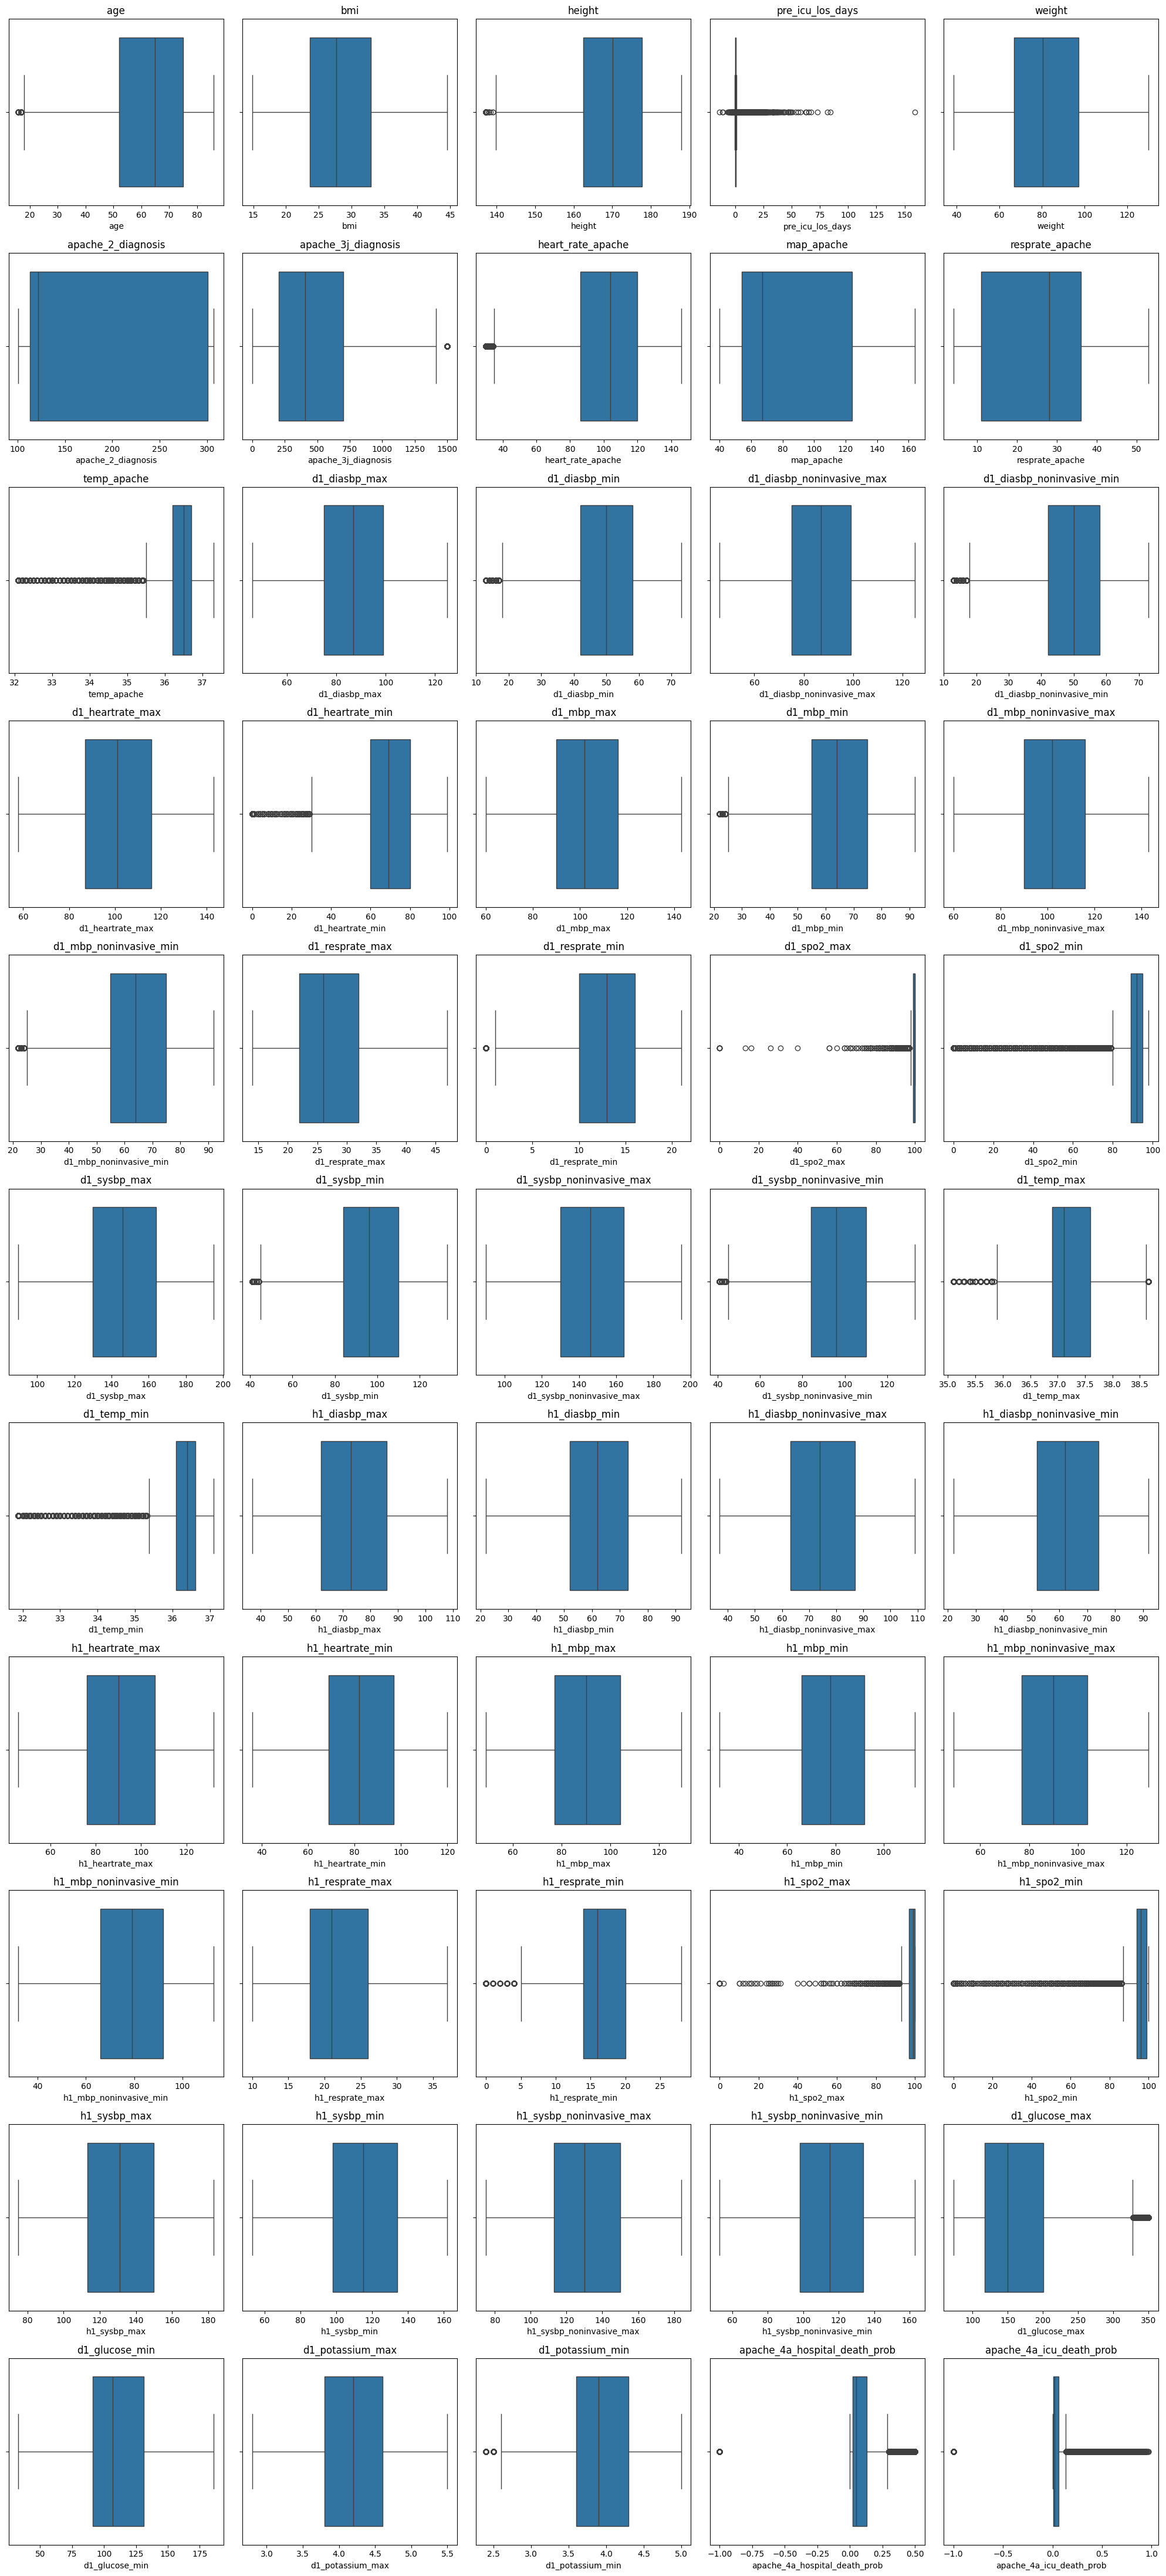

In [ ]:
# Setting the number of columns in the grid of subplots
ncols = 5
# Calculating the required number of rows based on the number of numerical columns
nrows = (len(numeric_columns) + ncols - 1) // ncols

# Setting the size of the entire figure (width, height in inches)
plt.figure(figsize=(ncols * 4, nrows * 4))

for i, col in enumerate(numeric_columns):
    # Adding a subplot for each numerical column
    plt.subplot(nrows, ncols, i + 1)
    # Using seaborn to create the boxplot
    sns.boxplot(x=X_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

As shown in the outlier analysis earlier in the report, we are dealing with skewed data characterized by numerous outliers.
Given the nature of the clinical data under analysis, it is crucial to approach outlier handling with caution. This is because some clinical features inherently contain valid extreme values that are essential for accurate predictions.

[citation:
Qiao, H., Chen, Y., Qian, C. et al. Clinical data mining: challenges, opportunities, and recommendations for translational applications. J Transl Med 22, 185 (2024). https://doi.org/10.1186/s12967-024-05005-0 ]


Capturing and analyzing extreme fluctuations in vital signs is vital for early intervention and predicting critical events such as hypotension in ICU settings.
For these reasons, we have decided to exclude features related to ICU settings from outlier deletion.

[citation:
Yoon JH, Jeanselme V, Dubrawski A, Hravnak M, Pinsky MR, Clermont G. Prediction of hypotension events with physiologic vital sign signatures in the intensive care unit. Crit Care. 2020 Nov 25;24(1):661. doi: 10.1186/s13054-020-03379-3. PMID: 33234161; PMCID: PMC7687996.]

**Appling the preprocessor again after deleting the outliers:**

In [ ]:
# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting columns names
new_columns = preprocessor.get_feature_names_out()

# Data Imbalance


As shownearlier in the report, the datased is highly imbalanced. There are many more patients who did not experience in-hospital death than cases of in-hospital death.

Let's check if the model did predict an imbalanced results:

In [ ]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Generate cross-validated predictions for the training set using the transformed features
y_pred = cross_val_predict(model, X_train_transformed, y_train, cv=cv)

# Print classification report to see the performance on each class
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     67042
           1       0.65      0.34      0.44      6328

    accuracy                           0.93     73370
   macro avg       0.80      0.66      0.70     73370
weighted avg       0.92      0.93      0.92     73370



As we see the model has shown better performance for “0” label than “1” due to an unbalanced dataset.

This class imbalance can lead to biased models that favor the majority class and perform poorly in predicting the minority class.

We use SMOTE to address this problem,as is it a popular technique used to address class imbalance by oversampling the minority class.

In [ ]:
# appling SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# # Now perform cross-validation with the balanced dataset
# model_1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# cv_results_smote = cross_validate(model_1, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc')
# average_auc = np.mean(cv_results_smote['test_score'])
# print(f"Average ROC AUC Score: {average_auc:.3f}")

By balancing the dataset first, prior to conducting feature selection and dimensionality reduction, we ensure that the feature selection process considers the predictive importance of features across all classes more equitably, not favoring features that are more predictive of the majority class.

# Exploring feature importance- Model explanability

Since we have a large number of features, we want to get a "feeling" regarding their relative contribution to the model. Therefore, exploring this on the train set, will help us to understand if we have some consistent fields with significant impact on our model.

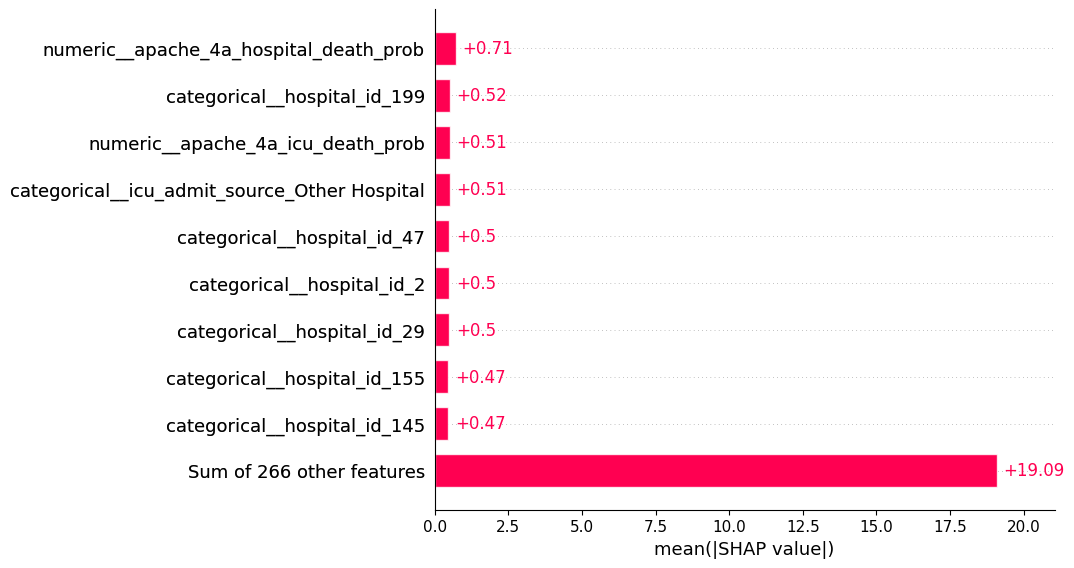

In [27]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train_transformed)
shap_df = pd.DataFrame(shap_values, columns=new_columns)
# Bar Plot
fig_1 = shap.plots.bar(explainer(shap_df))

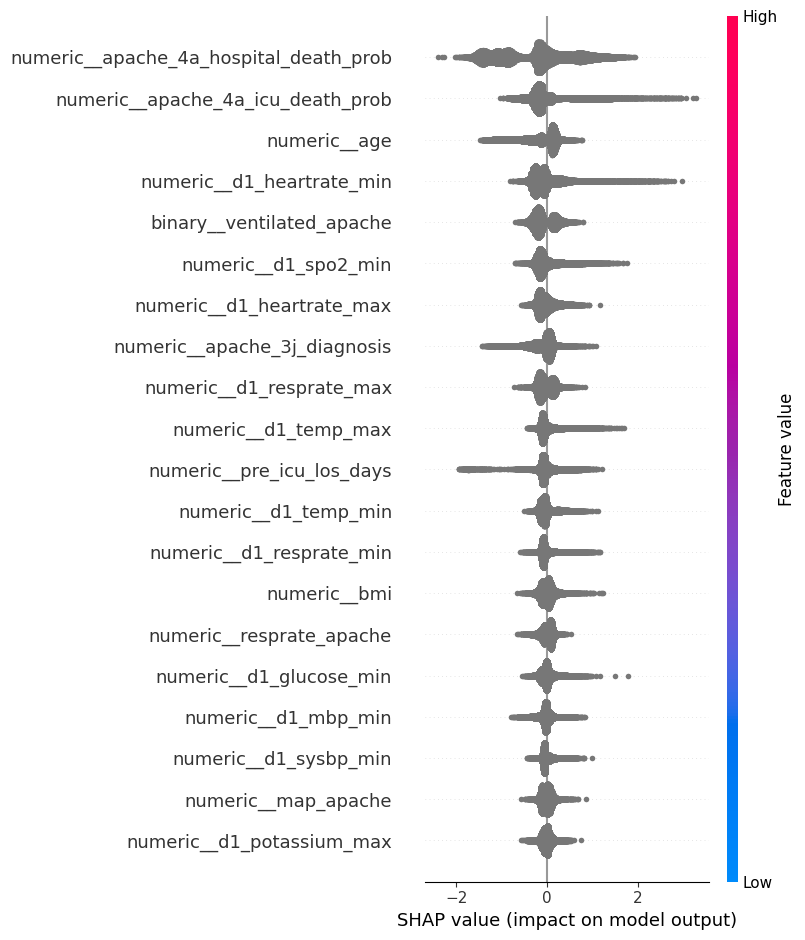

In [28]:
# Summerize plot
fig= shap.summary_plot(shap_values, X_train_transformed, feature_names=new_columns)

SHAP values offer insights into how each feature in the dataset contributes, either positively or negatively, to the target variable.

Our SHAP analysis indicates that 129 features contribute minimally to the model, each with less than a 0.2 contribution. Nevertheless, the their combined effect of these features amounts to a significant total of +5.08.

This suggests that these features, while weak on their own, provide substantial information when aggregated. This is a common scenario in complex models where multiple minor factors collectively influence the outcome.

Therefore, given their collective importance, removing these features without further analysis could potentially degrade the model’s performance.

Given the high dimensionality which complicates feature selection, we will continue with dimensionality reduction strategy.

# Exploring errors

ValueError: 'c' argument has 1109 elements, which is inconsistent with 'x' and 'y' with size 1.

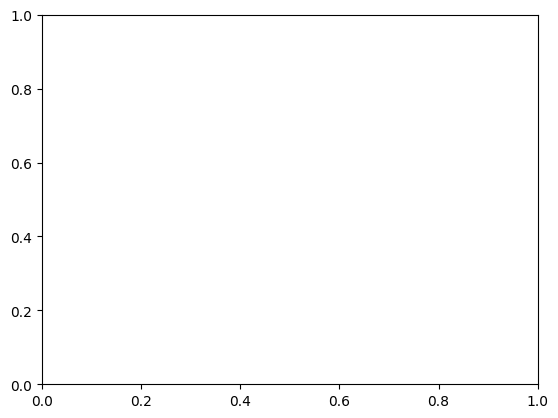

In [36]:
# Collect misclassified instances
misclassified_indices = np.where(y_pred_binary != y_valid_test)[0]

# Analyze features of misclassified instances
misclassified_features = X_test_transformed[misclassified_indices]
misclassified_labels = y_valid_test.iloc[misclassified_indices]
misclassified_predictions = y_pred_binary[misclassified_indices]

# Visualize misclassified instances and their features
plt.scatter(misclassified_features[:, 0], misclassified_features[:, 1], c=misclassified_labels, cmap='coolwarm', marker='x', label='True Label')
plt.scatter(misclassified_features[:, 0], misclassified_features[:, 1], c=misclassified_predictions[:, 1], cmap='coolwarm', marker='o', label='Predicted Probability')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Misclassified Instances and Predicted Probabilities')
plt.legend()
plt.show()

# Analyze feature importance
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = sorted_indices[:5]  # Top 5 most important features
print("Top 5 most important features:", top_features)

# Sample analysis of misclassified instances
sample_indices = misclassified_indices[:5]
for idx in sample_indices:
    print("Instance:", idx)
    print("Features:", X_test[idx])
    print("True Label:", y_test[idx])
    print("Predicted Probability:", y_pred[idx])


# Dimensionality Reduction



Singular Value Decomposition (TruncatedSVD) is a dimensionality reduction technique, based on singular value decomposition, that is particularly useful for sparse matrices.
It enables to reduce the dimensionality of the input data while preserving its essential structure and most of its variance.  It achieves this by capturing the most significant patterns and relationships in the data, as represented by the largest singular values and their corresponding singular vectors.
The final output, is a lower dimentional representation more managable and efficient for further analyzing.

Cumulative Explained Variance: [0.20959724 0.30432126 0.37850619 0.41781857 0.45909469 0.49938054
 0.53268186 0.56511371 0.59565292 0.62303896 0.6470224  0.67051369
 0.69247382 0.71177292 0.73039616 0.74832139 0.7646772  0.77891346
 0.79271284 0.80526184 0.81720273 0.82756706 0.83728094 0.84615072
 0.85465679 0.86269068 0.87028255 0.8774584  0.88431855 0.89058587
 0.89610167 0.90133525 0.90604605 0.91057439 0.91487039 0.91885246
 0.92258954 0.9262184  0.9294305  0.93262948 0.93546912 0.938261
 0.9409796  0.94353704 0.94587264 0.94813474 0.95032023 0.95248946
 0.95451727 0.95641796 0.95819755 0.95982358 0.96140935 0.96297759
 0.96449599 0.96595551 0.96731536 0.96855807 0.96978352 0.97087889
 0.97191678 0.97292495 0.97387058 0.97480196 0.97568752 0.97649981
 0.97724435 0.97797862 0.97864086 0.97927278 0.97987973 0.98046958
 0.98103786 0.98157172 0.98208392 0.98258707 0.98308872 0.98356761
 0.98400038 0.98440779 0.98479946 0.98517592 0.9855413  0.98589898
 0.98624153 0.98657476 0.98689755

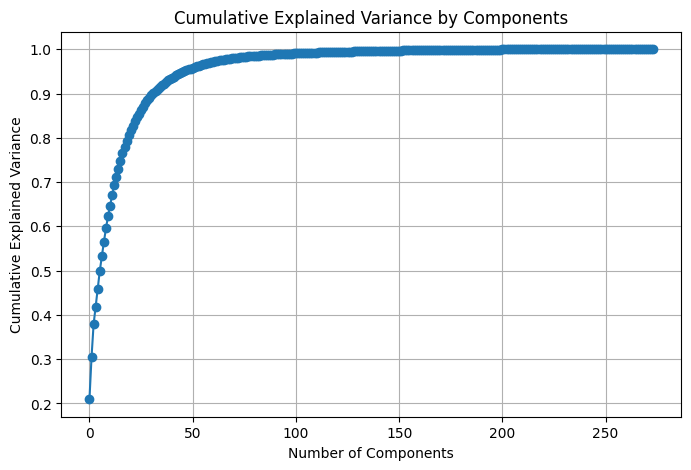

Number of components capturing at least 80% variance: 20


In [ ]:
# Applying Truncated SVD
svd = TruncatedSVD(n_components=X_train_smote.shape[1] - 1)
X_train_svd = svd.fit_transform(X_train_smote)

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Components')
plt.grid(True)
plt.show()

# Selecting the number of components that explain at least 90% of the variance
n_components = np.argmax(cumulative_variance >= 0.80) + 1
print("Number of components capturing at least 80% variance:", n_components)

# Re-applying SVD with optimal number of components
optimal_svd = TruncatedSVD(n_components=10)
X_train_svd = optimal_svd.fit_transform(X_train_smote)

In [ ]:
# # Visual inspection of the reduced components using t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# X_train_tsne = tsne.fit_transform(X_train_svd)

# # Plotting t-SNE output
# plt.figure(figsize=(8, 6))
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.5)
# plt.title('t-SNE visualization of the dataset after SVD')
# plt.xlabel('t-SNE Feature 1')
# plt.ylabel('t-SNE Feature 2')
# plt.show()

# # Additional validation using clustering
# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(X_train_svd)
# silhouette_avg = silhouette_score(X_train_svd, clusters)
# print("Silhouette Score for the clusters: {:.3f}".format(silhouette_avg))

in the case of SVD, each component is represented as a linear combination of the original features. Visualizing these components can provide insights into the patterns they capture


# Feature selection

# Hyper parameter tuning + performing a new improved model

Extreme Gradient Boosting (XGBoost) is an efficient implementation of the gradient boosting algorithm, which builds multiple decision trees sequentially. Each tree is trained to correct the errors made by the previous trees, and gradually improving the overall model's performance.

The model has variety of hyper-parameter that can adjust corresponding to reqierments and affect the model performance.
We chose to optimize the following parameters:
1. Tree Depth (max_depth): This hyperparameter specifies the maximum depth of each decision tree in the ensemble. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
2. Learning Rate (learning_rate):controls the contribution of each tree to the ensemble. A lower learning rate requires more trees to achieve the same level of model performance but can improve generalization.
3. Boosting Rounds (n_estimators): This hyperparameter determines the number of trees to be built. A higher number of boosting rounds can improve the model's performance, but it also increases the risk of overfitting.
4. Subsample (subsample): This hyperparameter specifies the fraction of training data to be used for each boosting round. It can help prevent overfitting by introducing randomness into the training process.
5. Column Subsampling by Tree (colsample_bytree): This hyperparameter controls the fraction of features (columns) to be randomly sampled for each tree. It helps introduce diversity into the ensemble and can reduce overfitting.
6. Gamma (gamma): Specifies the minimum reduction in the loss function required to make a further partition on a leaf node of the tree. It acts as regularization by controlling the tree's growth and can prevent overfitting.
7. Minimum Child Weight (min_child_weight): Specifies the minimum sum of instance weight (hessian) needed in a child (leaf) node. It helps control the tree's complexity and can prevent overfitting by requiring a minimum amount of data in each leaf node.


In [ ]:
# Performing an XGBoost classifier

# Define model
model = xgb.XGBClassifier()

# Define parameters for hyper-parameters tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train, X_valid_test, y_valid_train, y_valid_test = train_test_split(X_train_svd, y_train_smote, test_size=0.2)

  # Apply preprocessing on validation and test data
  X_valid_train_transformed = X_valid_train
  X_valid_test_transformed = X_valid_test

  # Hyperparameter tuning using GridSearchCV
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
  grid_search.fit(X_valid_train_transformed, y_valid_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  print("Best Hyperparameters:", best_params)
  print("Best Score:", best_score)

  # Training the model with best hyperparameters
  model.set_params(**best_params)
  model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = model.predict_proba(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred = model.predict_proba(X_test_transformed)
auc_score = roc_auc_score(y_test, y_pred[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

# Plot ROC curve

# mean validation set
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


KeyboardInterrupt: 